SECTION 1 — Preparations

Text(0.5, 1.0, 'Original Image')

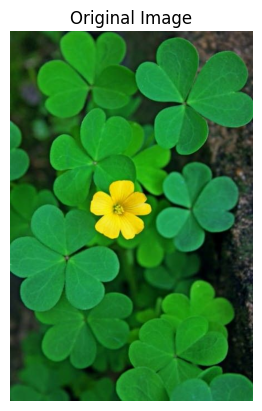

In [62]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open("/content/plants.jpeg")
img = np.array(img).astype(np.float32)

plt.imshow(img.astype(np.uint8))
plt.axis("off")
plt.title("Original Image")


Text(0.5, 1.0, 'Grayscale Image')

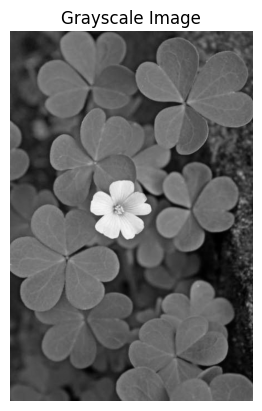

In [63]:
def rgb_to_gray(img):
    return 0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]

gray = rgb_to_gray(img)

plt.imshow(gray, cmap='gray')
plt.axis("off")
plt.title("Grayscale Image")


PART A — Convolution & Blurring

In [64]:
def convolve(img, kernel):
    """
    img: 2D numpy array (grayscale)
    kernel: 2D numpy array
    """
    kh, kw = kernel.shape
    pad_h, pad_w = kh//2, kw//2

    # reflect padding
    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    out = np.zeros_like(img)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+kh, j:j+kw]
            out[i, j] = np.sum(region * kernel)

    return out


In [65]:
def average_blur_gray(img, ksize):
    kernel = np.ones((ksize, ksize)) / (ksize * ksize)
    return convolve(img, kernel)


In [66]:
def average_blur_rgb(img, ksize):
    blurred = np.zeros_like(img)
    for c in range(3):
        blurred[..., c] = average_blur_gray(img[..., c], ksize)
    return blurred


In [67]:
def gaussian_kernel(ksize, sigma):
    ax = np.arange(-(ksize//2), ksize//2 + 1)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= np.sum(kernel)

    return kernel


In [68]:
g_kernel = gaussian_kernel(5, 1.0)

gauss_gray = convolve(gray, g_kernel)

gauss_rgb = np.zeros_like(img)
for c in range(3):
    gauss_rgb[..., c] = convolve(img[..., c], g_kernel)


(np.float64(-0.5), np.float64(439.5), np.float64(670.5), np.float64(-0.5))

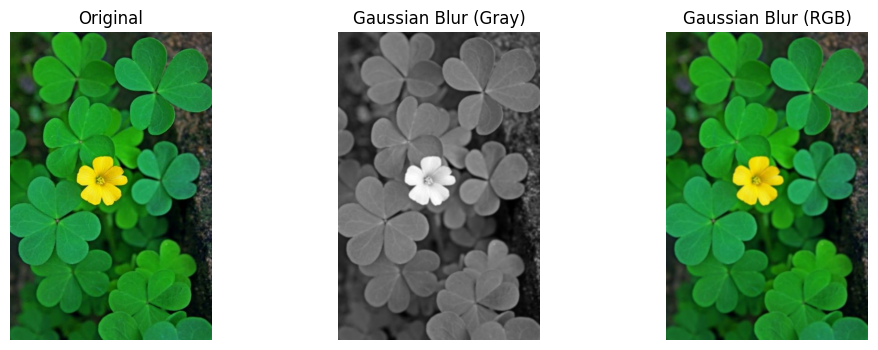

In [69]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img.astype(np.uint8))
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gauss_gray, cmap='gray')
plt.title("Gaussian Blur (Gray)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(gauss_rgb.astype(np.uint8))
plt.title("Gaussian Blur (RGB)")
plt.axis("off")


PART B — Sobel Edge Detection

In [70]:
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_y = np.array([
    [-1, -2, -1],
    [ 0,  0,  0],
    [ 1,  2,  1]
])


In [71]:
Gx = convolve(gray, sobel_x)
Gy = convolve(gray, sobel_y)

grad_mag = np.sqrt(Gx**2 + Gy**2)
grad_mag = (grad_mag / grad_mag.max()) * 255
grad_mag = grad_mag.astype(np.uint8)


(np.float64(-0.5), np.float64(439.5), np.float64(670.5), np.float64(-0.5))

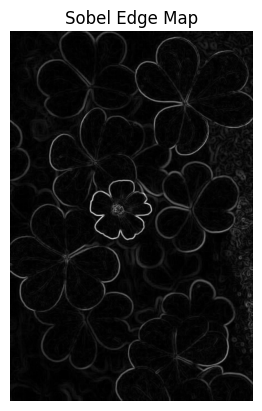

In [72]:
plt.imshow(grad_mag, cmap='gray')
plt.title("Sobel Edge Map")
plt.axis("off")


PART C — Sharpening

In [73]:
laplacian_kernel = np.array([
    [0,  1, 0],
    [1, -4, 1],
    [0,  1, 0]
])


In [74]:
lap = convolve(gray, laplacian_kernel)

alpha = 1
sharp = gray - alpha * lap


In [75]:
import cv2

cv_lap = cv2.Laplacian(gray, cv2.CV_32F, ksize=3)
cv_sharp = gray - cv_lap

print("Are outputs identical?",
      np.allclose(sharp, cv_sharp))


Are outputs identical? False


In [76]:
blurred = convolve(gray, g_kernel)

mask = gray - blurred

alpha = 0.7
unsharp = gray + alpha * mask


(np.float64(-0.5), np.float64(439.5), np.float64(670.5), np.float64(-0.5))

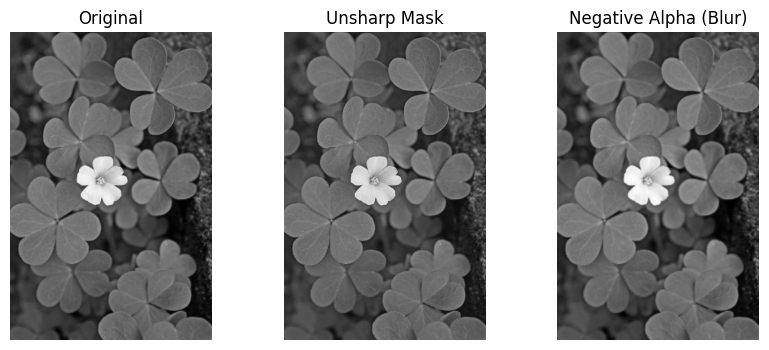

In [77]:
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.imshow(gray, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(unsharp, cmap='gray')
plt.title("Unsharp Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(gray + (-0.5)*mask, cmap='gray')
plt.title("Negative Alpha (Blur)")
plt.axis("off")


PART D — Frequency Analysis

In [78]:
def magnitude_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    mag = np.log(1 + np.abs(fshift))
    return mag


Text(0.5, 1.0, 'Unsharp Spectrum')

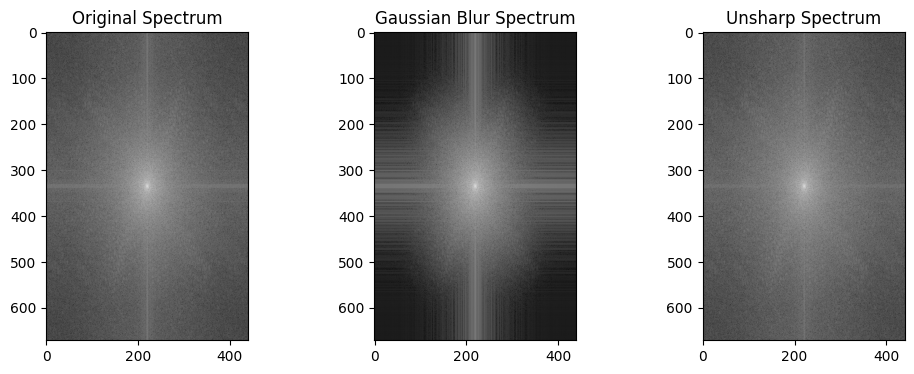

In [79]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(magnitude_spectrum(gray), cmap='gray')
plt.title("Original Spectrum")

plt.subplot(1,3,2)
plt.imshow(magnitude_spectrum(blurred), cmap='gray')
plt.title("Gaussian Blur Spectrum")

plt.subplot(1,3,3)
plt.imshow(magnitude_spectrum(unsharp), cmap='gray')
plt.title("Unsharp Spectrum")


PART E — Custom Colour Kernel (Yellow Leaf)

In [80]:
R, G, B = img[...,0], img[...,1], img[...,2]

RG_diff = R - G


In [81]:
edge_kernel = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])


In [82]:
resp_r = convolve(R, edge_kernel)
resp_g = convolve(G, edge_kernel)

yellow_edge = np.abs(resp_r - resp_g)

yellow_edge = (yellow_edge / yellow_edge.max()) * 255


(np.float64(-0.5), np.float64(439.5), np.float64(670.5), np.float64(-0.5))

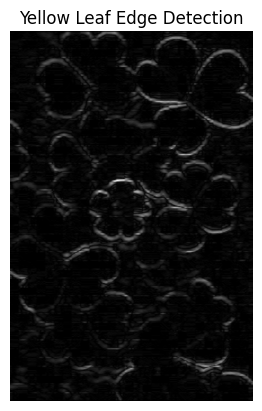

In [83]:
plt.imshow(yellow_edge, cmap='gray')
plt.title("Yellow Leaf Edge Detection")
plt.axis("off")


BONUS — Part F (HSV manipulation)

In [84]:
hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV)

# yellow mask
lower = np.array([20, 80, 80])
upper = np.array([35, 255, 255])

mask = cv2.inRange(hsv, lower, upper)

# change hue to red
hsv[mask > 0, 0] = 0

result = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


Text(0.5, 1.0, 'Yellow → Red')

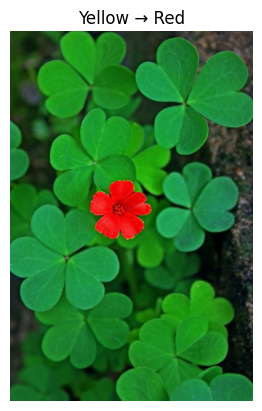

In [85]:
plt.imshow(result)
plt.axis("off")
plt.title("Yellow → Red")
